In [191]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
import seaborn as sns
import pandas as pd
import umap
from scipy.spatial.distance import cdist
from tqdm import tqdm

import os

from src.models import LinearDecoder
from src.utils import ratemap_collage, SimpleDatasetMaker, get_ratemaps

plt.rcdefaults()
plt.style.use("figures/project_style.mplstyle")
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
figure_path = os.path.join(os.getcwd(), "figures")
model_path = os.path.join(os.getcwd(), "models")
results_path = os.path.join(os.getcwd(), "results")

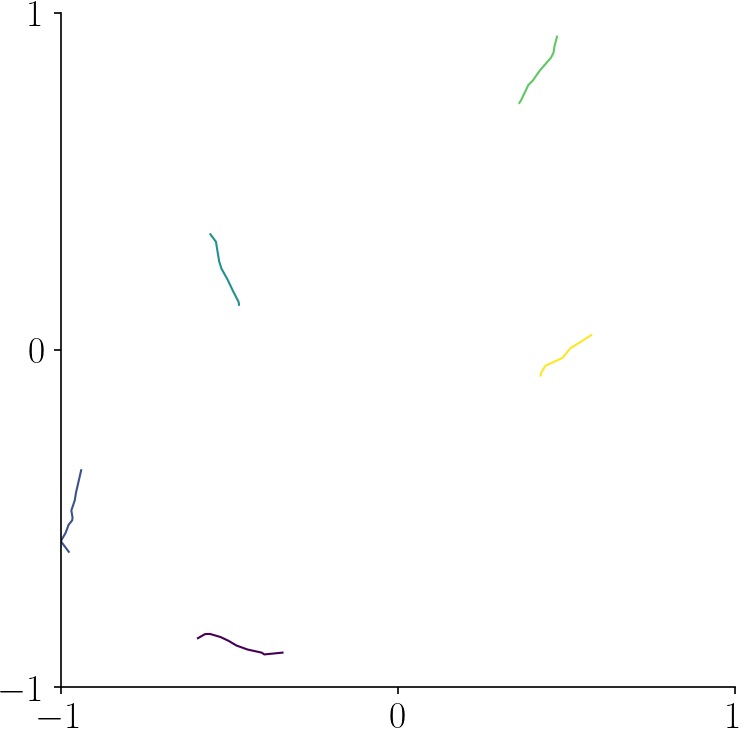

In [3]:
cmap = plt.get_cmap("viridis")
genny = SimpleDatasetMaker()
r, v = genny.generate_dataset(5, 10)
colors = [cmap(i) for i in np.linspace(0, 1, r.shape[0])]

fig, ax = plt.subplots(figsize=(5, 5))
for k, traj in enumerate(r):
    ax.plot(*traj.detach().numpy().T, color=colors[k], lw=1)
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)
ax.set_xticks(np.linspace(-1, 1, 3))
ax.set_yticks(np.linspace(-1, 1, 3))
ax.set_aspect('equal')
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_example_trajectories.svg'), transparent=True)

In [193]:
model_name_map = {
    "256": "without context",
    "256_context": "with context",
    
    # "long_trajectory_rnn": "long trajectory",
    
    # "256_0beta": r"$n=256 \: \beta=0$",
    # "256_025beta": r"$n=256 \: \beta=0.25$",
    # "256_075beta": r"$n=256 \: \beta=0.75$",
    # 
    # # Scale grid
    # "256_01scale": r"$n=256 \: \sigma=0.1$",
    # "256_05scale": r"$n=256 \: \sigma=0.5$",
    # 
    # # n grid
    # "512": r"$n=512$",
    # "1024": r"$n=1024$",
    # 
    # "256_context": r"$n=256 \: context$",
    # "256_ff_context": r"$n=256 \: ff \: context$",
}

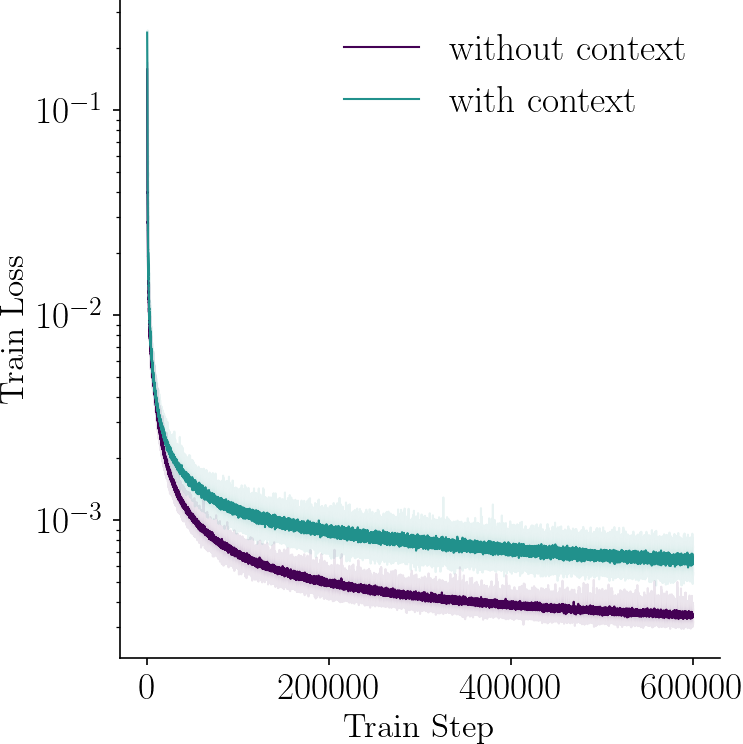

In [195]:
# Load models and loss histories
models, loss_histories = {}, {}
for name in model_name_map.keys():
    models[name] = [torch.load(os.path.join(model_path, f"{name}_{i}.pt")) for i in range(20) if os.path.exists(os.path.join(model_path, f"{name}_{i}.pt"))]
    loss_histories[name] = [np.load(os.path.join(model_path, f"{name}_{i}_loss_history.npy")) for i in range(20) if os.path.exists(os.path.join(model_path, f"{name}_{i}_loss_history.npy"))]

    # Remove if empty
    if len(models[name]) == 0:
        del models[name]
        del loss_histories[name]
        
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 0.5, len(models))]

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
for i, (name, loss_history) in enumerate(loss_histories.items()):
    ax.semilogy(np.arange(len(loss_history[0])) * 10, np.mean(loss_history, axis=0), label=model_name_map[name], color=colors[i], lw=1)
    ax.fill_between(np.arange(len(loss_history[0])) * 10, np.min(loss_history, axis=0), np.max(loss_history, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Train Step")
ax.set_ylabel("Train Loss")
ax.legend()
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_long_traj_loss.svg'), transparent=True)

## Ratemaps

In [196]:
model = models["256"][0]

In [198]:
timesteps = 10
bins = 128
ratemaps = get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=500000)

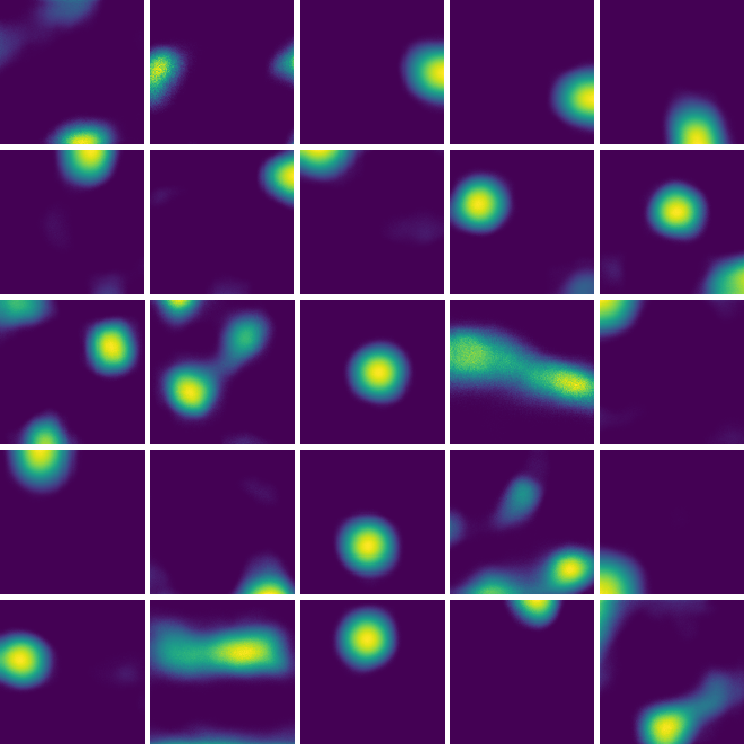

In [199]:
# Plot first 25 ratemaps (active units)
plt_ratemaps = ratemaps[np.nanmean(ratemaps, axis=(1, 2)) > 0.0]
fig, ax = ratemap_collage(plt_ratemaps[:25], cols=5, cmap="viridis", vmin=0)
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_ratemaps.svg'), transparent=True)

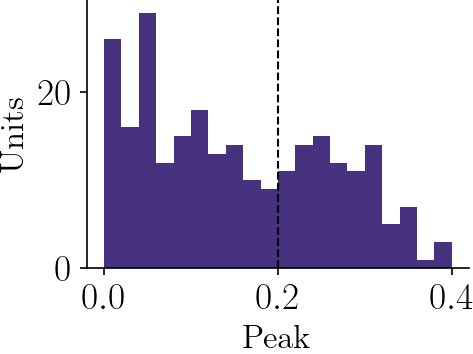

In [88]:
fig, ax = plt.subplots()
ax.hist(np.max(ratemaps, axis=(1, 2)), bins=np.arange(0, 0.42, 0.02))
ax.set_ylabel("Units")
ax.set_xlabel("Peak")
ax.axvline(0.2, color="black", linestyle="--")

fig.savefig(os.path.join(figure_path, 'rnn_peaks.svg'), transparent=True)   

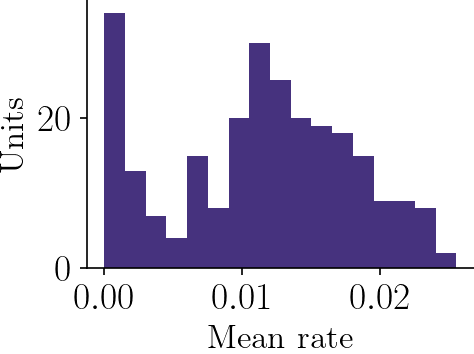

In [89]:
fig, ax = plt.subplots()
ax.hist(np.mean(ratemaps, axis=(1, 2)), bins=np.arange(0, 0.026, 0.0015))
ax.set_ylabel("Units")
ax.set_xlabel("Mean rate")

fig.savefig(os.path.join(figure_path, 'rnn_mean_rates.svg'), transparent=True) 

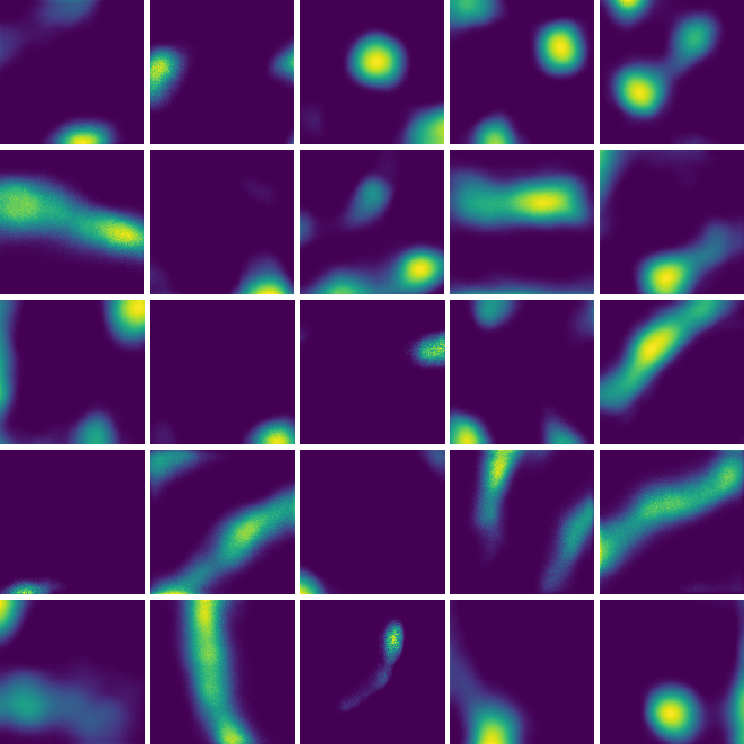

In [90]:
# Plot first 25 ratemaps (active units)
plt_ratemaps = ratemaps[(np.mean(ratemaps, axis=(1, 2)) > 0.0) & (np.max(ratemaps, axis=(1, 2)) < 0.19)]
fig, ax = ratemap_collage(plt_ratemaps[:25], cols=5, cmap="viridis")     
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_ratemaps_low_rate.svg'), transparent=True)

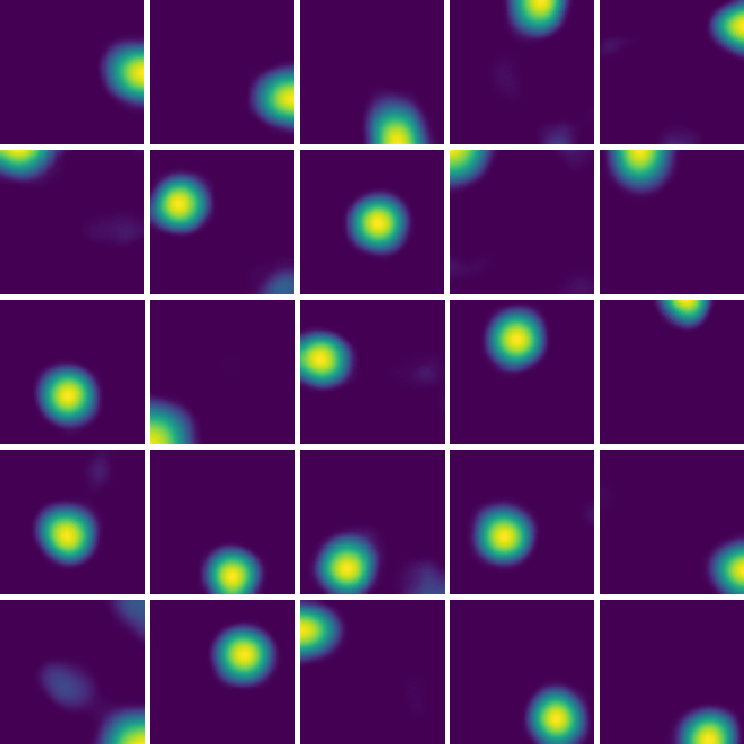

In [91]:
# Plot first 25 ratemaps (active units)
plt_ratemaps = ratemaps[np.max(ratemaps, axis=(1, 2)) >= 0.19]
fig, ax = ratemap_collage(plt_ratemaps[:25], cols=5, cmap="viridis")     
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_ratemaps_high_rate.svg'), transparent=True)

## Spatial similarity / Error maps

In [205]:
model_name = "256"
model = models[model_name][0]
pos_name = "center"
scale = 0.25
n = 128
beta = 0.5

positions = {
    'center': [64, 64],
    'corner': [0, 0],
    'bottom': [32, 64]
}

pos = positions[pos_name]

In [206]:
ratemaps = get_ratemaps(model, bins=n, timesteps=10, n_traj=100000)

In [207]:
p = ratemaps.reshape(model.n_out, -1).T 

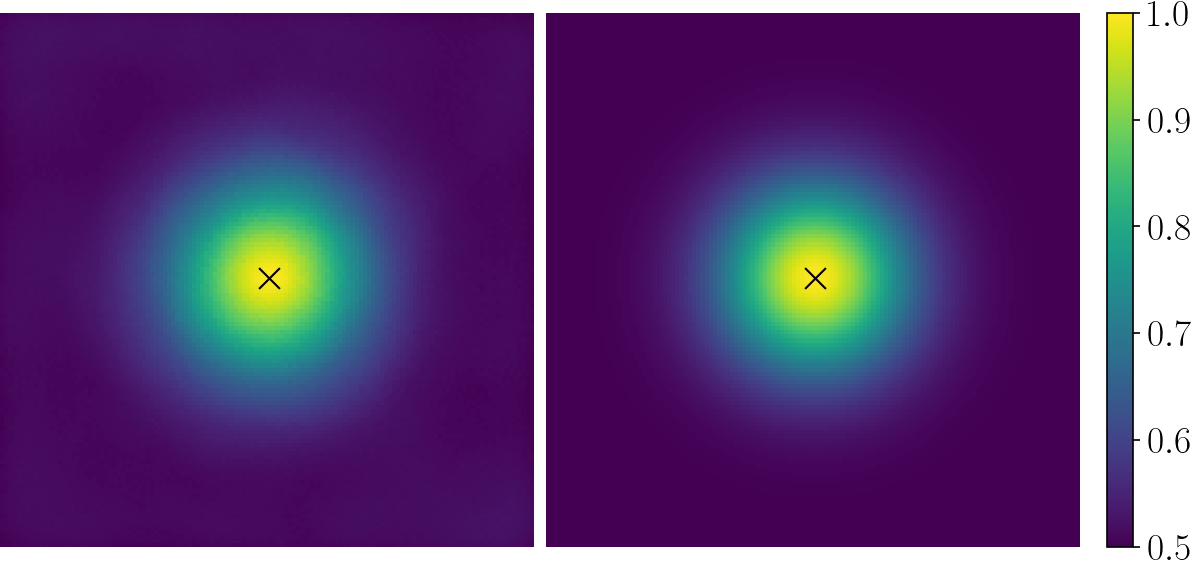

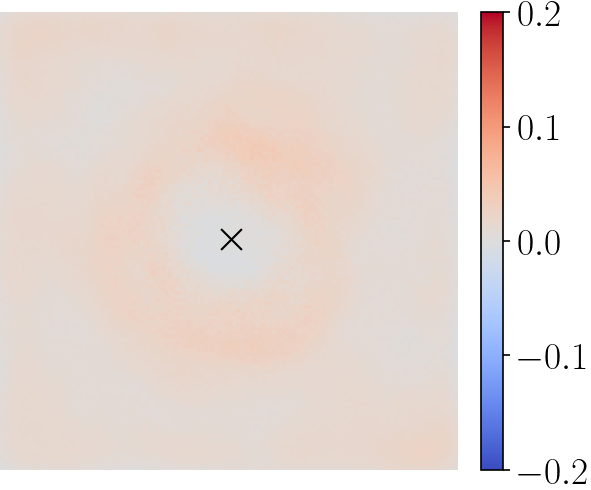

In [208]:
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)

# Define grid
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

# Compute position in flat array
pos_flat = np.ravel_multi_index(pos, (n, n))

# Compute similarity of the 'p' based on this, but with numpy
dp = cdist(p, p[pos_flat][None]) **2
corr = np.exp(-dp)

# Same for actual grid
grid_dist = cdist(grid, grid[pos_flat][None]) **2
grid_corr = np.exp((-0.5 / scale ** 2) * grid_dist)
grid_corr = (1 - beta) * grid_corr + beta

# Create figure
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

# Spatial representations
im = axs[0].imshow(corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0.5, vmax=1)
axs[0].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[0].axis("off")

# Grid
im = axs[1].imshow(grid_corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0.5, vmax=1)
axs[1].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[1].axis("off")
fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=.05)
plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_{pos_name}_{model_name}.svg'), transparent=True)

# Difference
fig, axs = plt.subplots(figsize=(4, 4))
# im = axs.imshow(np.abs(corr - grid_corr).reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=0.1)
# im = axs.imshow((corr - grid_corr).reshape(n, n), origin="lower", cmap="coolwarm", vmin=-0.05, vmax=0.05)
im = axs.imshow((corr - grid_corr).reshape(n, n), origin="lower", cmap="coolwarm", vmin=-0.2, vmax=0.2)
axs.scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs.axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs, orientation='vertical', fraction=.05)
plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_error_{pos_name}_{model_name}.svg'), transparent=True)

## Decoding

In [252]:
def population_decoding(p, memory, r_memory):
    """Population decoding scheme: decode location as location r_memory
       corresponding to most similar (closest) population vector in memory
       to current population vector p

    Args:
        p (N, n_p): population vectors to be decoded
        memory (M, n_p): memory of population vectors
        r_memory (M, 2): physical locations of memory vectors
    """
    dists = np.sum((p[None] - memory[:,None])**2, axis = -1) # (M, N)
    inds = np.argmin(dists, axis = 0) # (N)
    decoded_trajectories = r_memory[inds] #(N, 2)
    return decoded_trajectories


def train_decoder(model, train_steps, bs, timesteps, lr=1e-3):

    decoder = LinearDecoder(n_in=model.n_out, n_out=2)
    optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
    genny = SimpleDatasetMaker()

    decoder_history = []
    progress = tqdm(range(train_steps))
    for i in progress:
        r, v = genny.generate_dataset(bs, timesteps)

        # Train decoder on data from RNN model
        p = model.spatial_representation(v, model.initial_state(r[:,0]))[0].detach()
        p = torch.reshape(p, (-1, p.shape[-1]))
        r_label = r[:,1:].reshape(-1, 2)

        loss = decoder.train_step(x=p, y=r_label, optimizer=optimizer)

        if i % 10 == 0:
            progress.set_description(f"loss: {loss:>7f}")
        
        decoder_history.append(loss)

    return decoder, decoder_history


def evaluate_decoder(decoder, model, r, v):
    p = model.spatial_representation(v, model.initial_state(r[:,0]))[0].detach()
    decoder_pred = decoder(p).detach().numpy()
    decoder_error = np.linalg.norm(decoder_pred - r[:,1:].detach().numpy(), axis = -1)
    
    decoder_error = decoder_error.reshape(-1, v.shape[1])
    return decoder_error, decoder_pred, p.detach().numpy()


Comparison for one example model

In [272]:
model = models["256"][0]            # Select a model

n_eval = 256                        # Number of evaluation trajectories
t_eval = 20                         # Number of evaluation timesteps

colors = plt.get_cmap("viridis")(np.linspace(0, 1, 3))[:-1]

First, evaluate the linear decoder

loss: 0.000618: 100%|██████████| 10000/10000 [00:11<00:00, 907.46it/s]


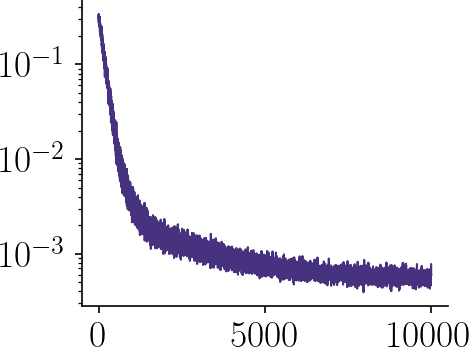

In [230]:
train_steps = 10000         # Number of training steps
bs = 64                     # Batch size
t_train = 10                # Number of training timesteps

decoder, decoder_history = train_decoder(model, train_steps, bs, t_train)

plt.plot(decoder_history)
plt.yscale("log")
plt.show()

In [248]:
r_eval, v_eval = SimpleDatasetMaker().generate_dataset(n_eval, t_eval)

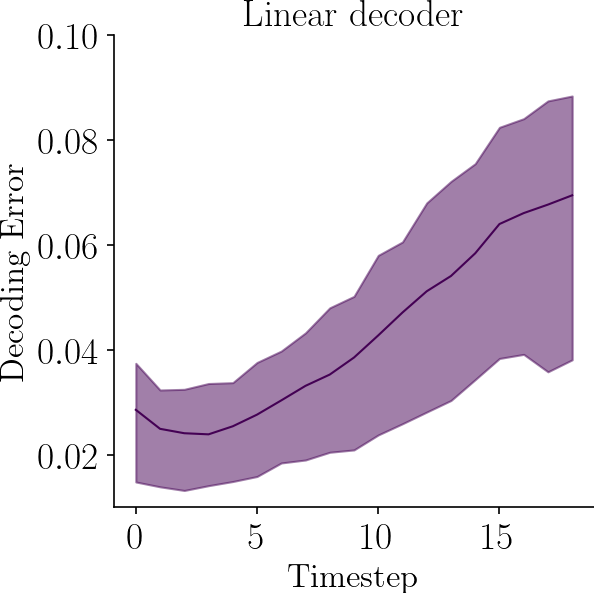

In [253]:
ld_error, ld_r_pred, p_eval = evaluate_decoder(decoder, model, r_eval, v_eval)
ld_error_quartiles = np.percentile(ld_error, [25, 75], axis=0)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(np.mean(ld_error, axis = 0), label="Linear decoder", color=colors[0])
ax.fill_between(np.arange(t_eval - 1), ld_error_quartiles[0], ld_error_quartiles[1], alpha=0.5, color=colors[0])
ax.set_xlabel("Timestep")
ax.set_ylabel("Decoding Error")
ax.set_ylim(0.01, 0.1)
ax.set_title("Linear decoder")
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_linear_decoding_error.svg'), transparent=True)

Now, evaluate the population decoding

In [254]:
res = 32            # Memory resolution
n_train = 5000      # Number of training trajectories
timesteps = 10      # Number of timesteps

# Form memory
ratemaps = get_ratemaps(model, bins=res, timesteps=timesteps, n_traj=n_train)
memory = ratemaps.reshape(model.n_out, -1).T
x = np.linspace(-1, 1, res+1)
y = x.copy()
xx = x[:-1] + np.diff(x) / 2
yy = y[:-1] + np.diff(y) / 2
xx, yy = np.meshgrid(xx,yy)
r_memory = np.stack((yy.ravel(), xx.ravel()), axis =-1)             # (Square) grid of memory locations

In [257]:
# Evaluate on unseen trajectories
# pop_r_eval, v_eval = SimpleDatasetMaker().generate_dataset(n_eval, t_eval)
# p_eval, _ = model.spatial_representation(v_eval, model.p0(pop_r_eval[:,0])[None])
# p_eval = p_eval.detach().numpy()

# Decode
pop_r_pred = population_decoding(p_eval.reshape(-1, p_eval.shape[-1]), memory, r_memory)
pop_r_pred = pop_r_pred.reshape(p_eval.shape[0], p_eval.shape[1], 2)

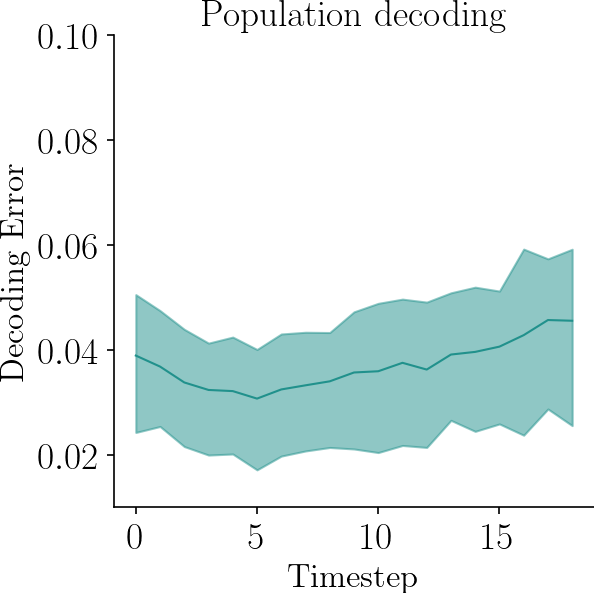

In [256]:
pop_error = np.linalg.norm(r_eval[:, 1:] - pop_r_pred, axis=-1)
pop_error_quartiles = np.percentile(pop_error, [25, 75], axis=0)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(np.mean(pop_error, axis=0), label="Population decoding", color=colors[1])
ax.fill_between(np.arange(t_eval - 1), pop_error_quartiles[0], pop_error_quartiles[1], alpha=0.5, color=colors[1])
ax.set_xlabel("Timestep")
ax.set_ylabel("Decoding Error")
ax.set_ylim(0.01, 0.1)
ax.set_title("Population decoding")
plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_population_decoding_error.svg'), transparent=True)

Decoded trajectories

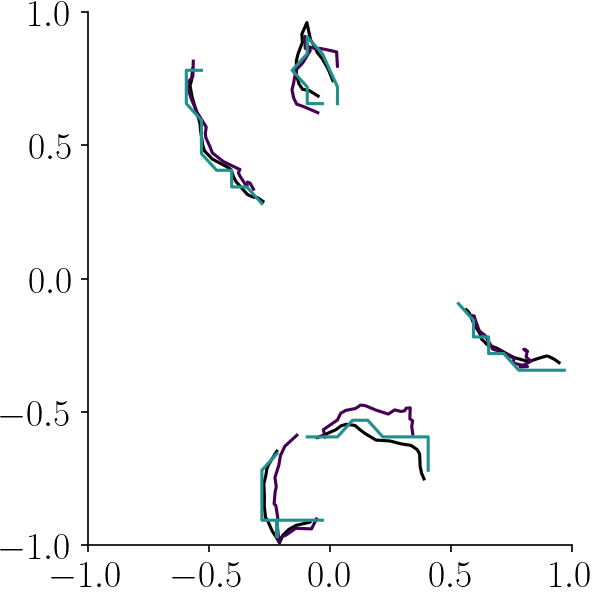

In [274]:
# Plot example trajectories
fig, ax = plt.subplots(figsize=(4, 4))
rand_idx = np.random.choice(n_eval, 5)
for i in rand_idx:
    ax.plot(r_eval[i, 1:, 0], r_eval[i, 1:, 1], label="Ground truth" if i == rand_idx[0] else None, color='black', lw=1.5)
    ax.plot(ld_r_pred[i, :, 0], ld_r_pred[i, :, 1], label="Linear decoder" if i == rand_idx[0] else None, color=colors[0], lw=1.5)
    ax.plot(pop_r_pred[i, :, 0], pop_r_pred[i, :, 1], label="Population decoding" if i == rand_idx[0] else None, color=colors[1], lw=1.5)
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Systematic comparison

In [19]:
t_eval, n_eval = 20, 256    # Eval params

t_train = 10                # Number of training timesteps

# Linear decoder
train_steps = 10000         # Number of training steps
bs = 64                     # Batch size

# Population decoding
res = 32            # Memory resolution
n_train = 5000      # Number of training trajectories

decoding_errors = []
for model in models["256"]:

    # Option 1: Linear decoder
    error_decoder = evaluate_decoder(train_decoder(model, train_steps, bs, t_train)[0], model, t_eval, n_eval)[0]

    decoding_errors.append(pd.DataFrame({
        "method": "Linear decoder",
        "error": error_decoder.mean(axis=0),
        "timestep": np.arange(t_eval - 1)
    }))

    # Option 2: Population decoding

    # Form memory
    ratemaps = get_ratemaps(model, bins=res, timesteps=t_train, n_traj=n_train)
    memory = ratemaps.reshape(model.n_out, -1).T
    x = np.linspace(-1, 1, res+1)
    y = x.copy()
    xx = x[:-1] + np.diff(x) / 2
    yy = y[:-1] + np.diff(y) / 2
    xx, yy = np.meshgrid(xx,yy)
    r_memory = np.stack((yy.ravel(), xx.ravel()), axis =-1)             # (Square) grid of memory locations

    # Evaluate on unseen trajectories
    r_eval, v_eval = SimpleDatasetMaker().generate_dataset(n_eval, t_eval)
    p_eval, _ = model.spatial_representation(v_eval, model.p0(r_eval[:,0])[None])
    p_eval = p_eval.detach().numpy()

    # Decode
    r_decoded = population_decoding(p_eval.reshape(-1, p_eval.shape[-1]), memory, r_memory)
    r_decoded = r_decoded.reshape(p_eval.shape[0], p_eval.shape[1], 2) #
    error_pop = np.linalg.norm(r_eval[:, 1:] - r_decoded, axis=-1)

    decoding_errors.append(pd.DataFrame({
        "method": "Population decoding",
        "error": error_pop.mean(axis=0),
        "timestep": np.arange(t_eval - 1)
    }))

decoding_errors = pd.concat(decoding_errors, ignore_index=True)

loss: 0.000547: 100%|██████████| 10000/10000 [00:08<00:00, 1134.55it/s]


/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_20468/1919027097.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ld_errors = decoding_errors[decoding_errors["method"] == "Linear decoder"].groupby("timestep").mean()
/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_20468/1919027097.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  quartiles = decoding_errors[decoding_errors["method"] == "Linear decoder"].groupby("timestep").quantile([0.25, 0.75]).unstack()
/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_20468/1919027097.py:7: FutureWarning: The default value of numeri

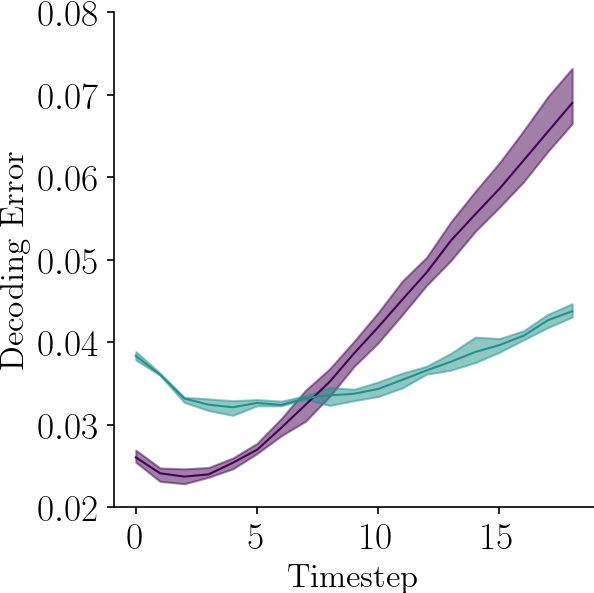

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
ld_errors = decoding_errors[decoding_errors["method"] == "Linear decoder"].groupby("timestep").mean()
ax.plot(np.arange(decoding_errors.timestep.min(), decoding_errors.timestep.max() + 1), ld_errors["error"], label="Linear decoder", color=colors[0], lw=1)
quartiles = decoding_errors[decoding_errors["method"] == "Linear decoder"].groupby("timestep").quantile([0.25, 0.75]).unstack()
ax.fill_between(np.arange(decoding_errors.timestep.min(), decoding_errors.timestep.max() + 1), quartiles["error", 0.25], quartiles["error", 0.75], alpha=0.5, color=colors[0])

pd_errors = decoding_errors[decoding_errors["method"] == "Population decoding"].groupby("timestep").mean()
ax.plot(np.arange(decoding_errors.timestep.min(), decoding_errors.timestep.max() + 1), pd_errors["error"], label="Population decoding", color=colors[1], lw=1)
quartiles = decoding_errors[decoding_errors["method"] == "Population decoding"].groupby("timestep").quantile([0.25, 0.75]).unstack()
ax.fill_between(np.arange(decoding_errors.timestep.min(), decoding_errors.timestep.max() + 1), quartiles["error", 0.25], quartiles["error", 0.75], alpha=0.5, color=colors[1])

ax.set_xlabel("Timestep")
ax.set_ylabel("Decoding Error")
ax.set_ylim(0.02, 0.08)
# ax.set_aspect('auto')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Method")
plt.show()

fig.savefig(os.path.join(figure_path, 'rnn_decoding_error_comparison.svg'), transparent=True)


## Context analysis

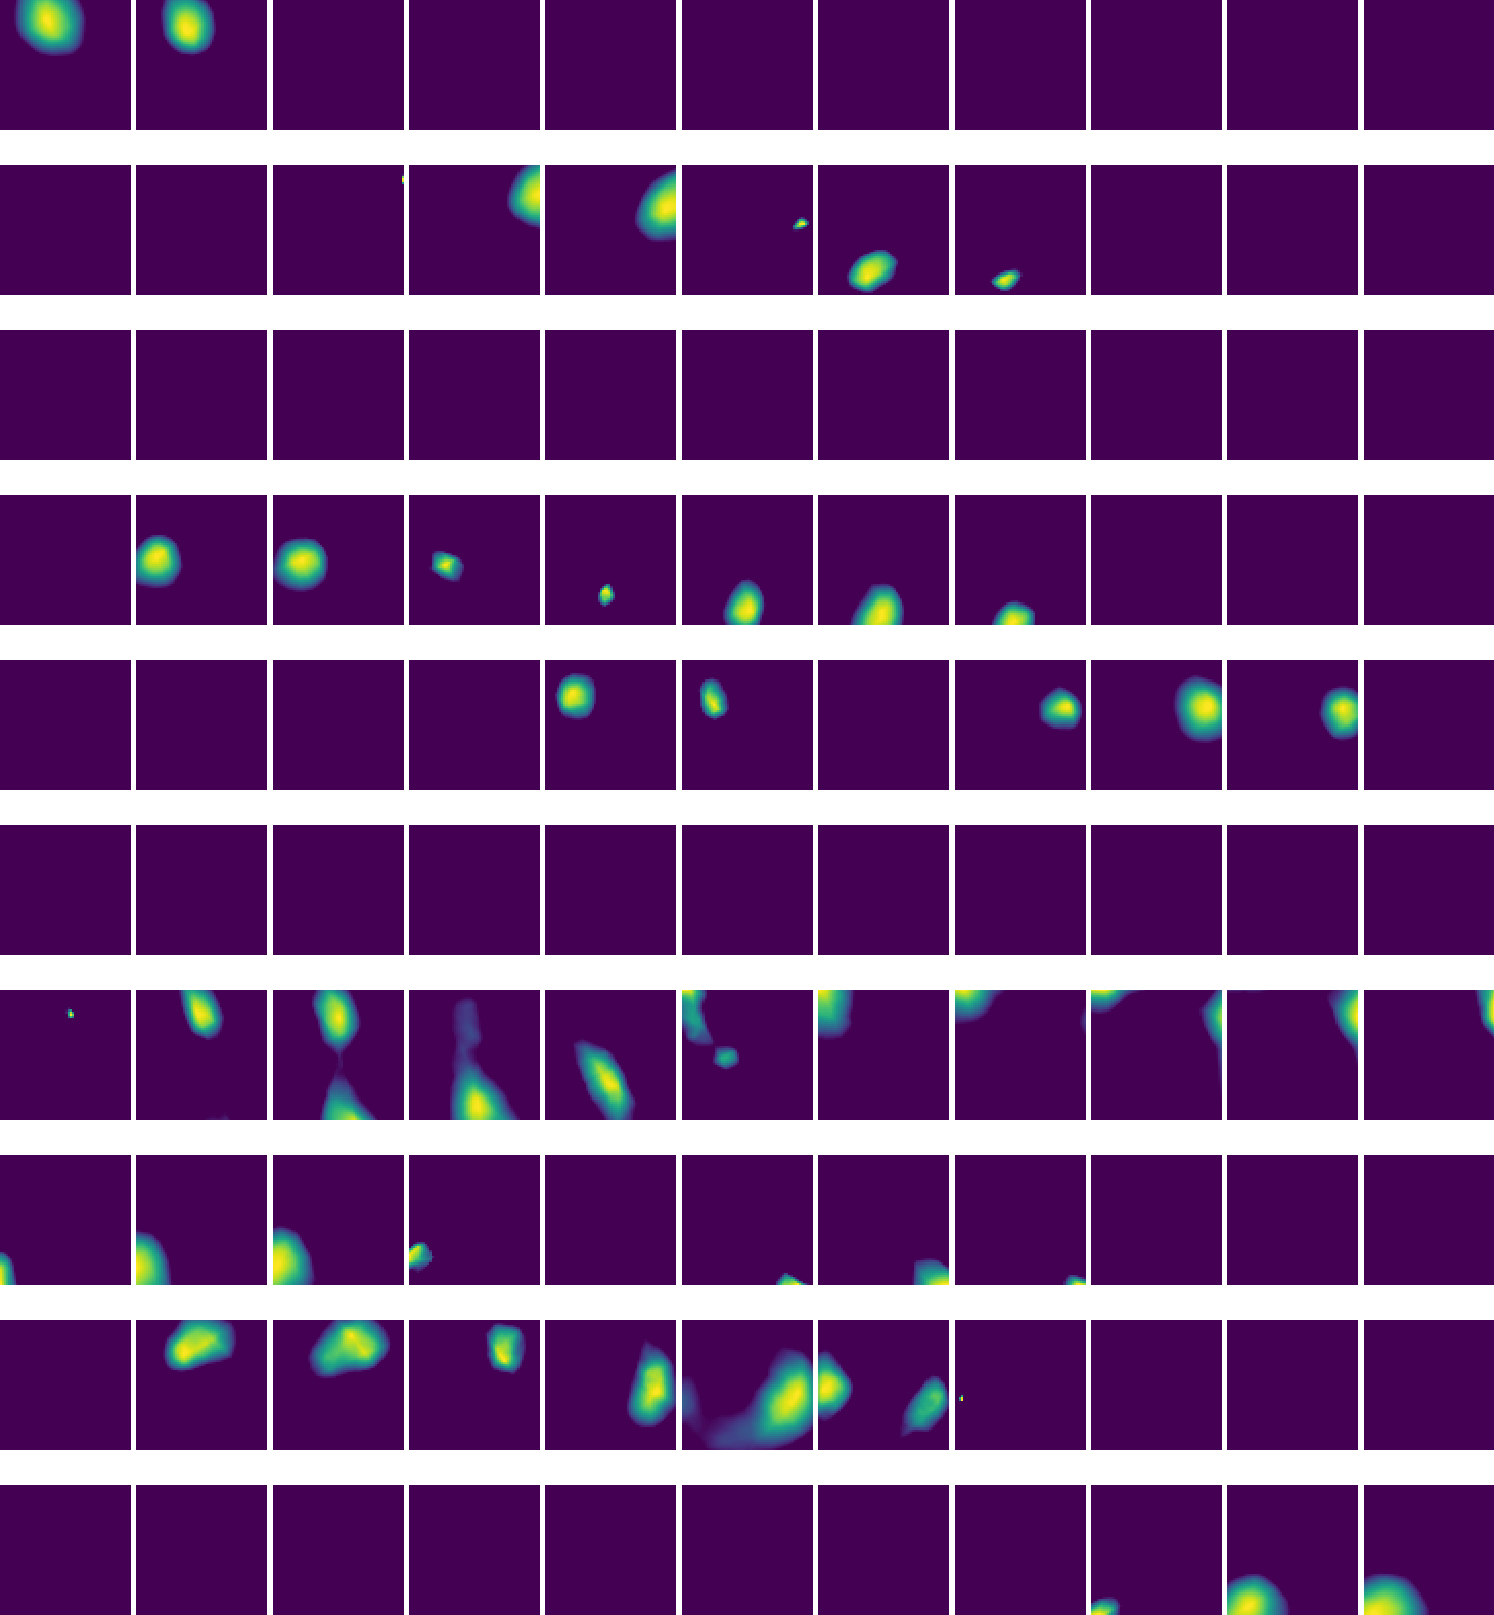

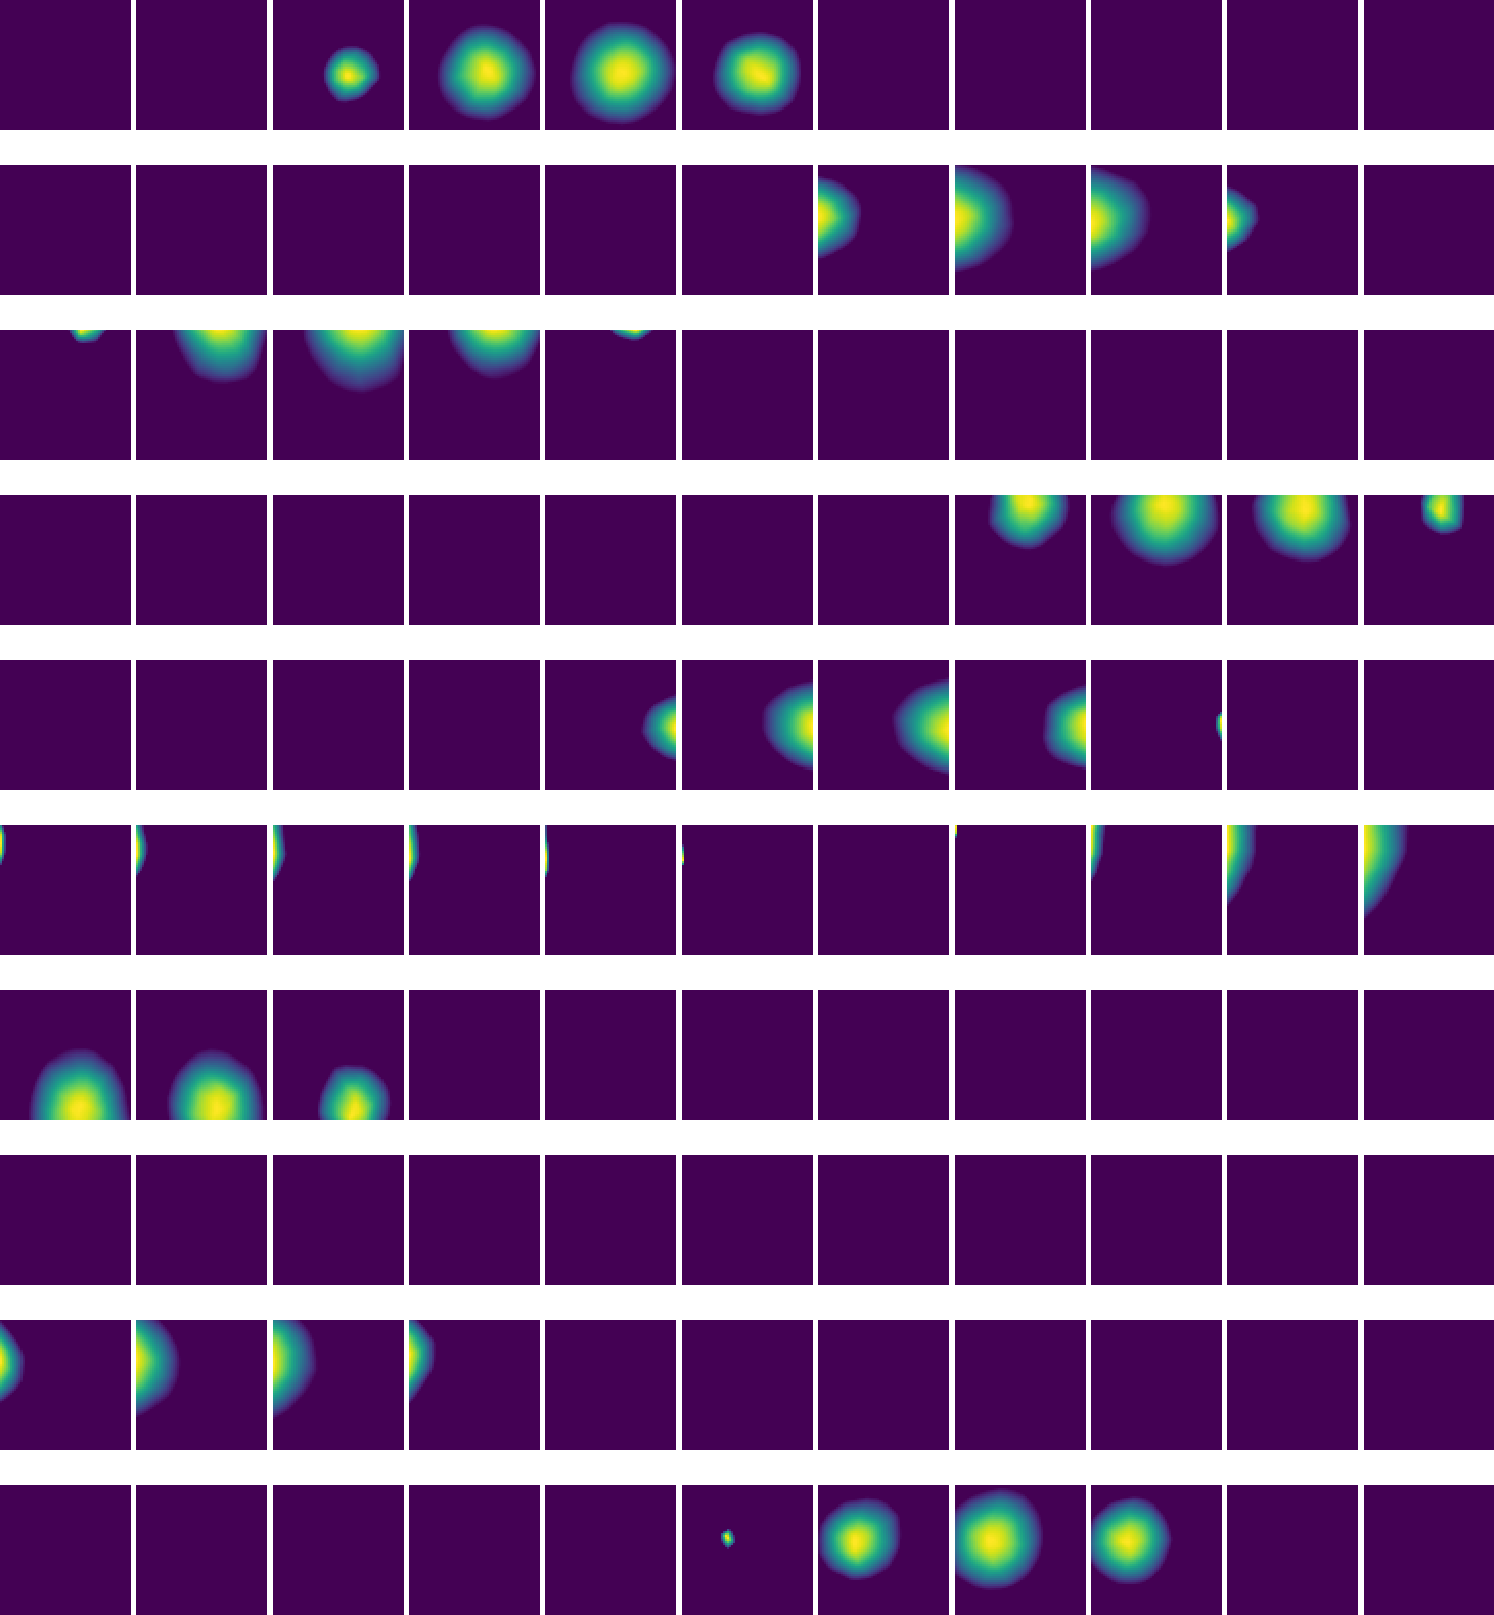

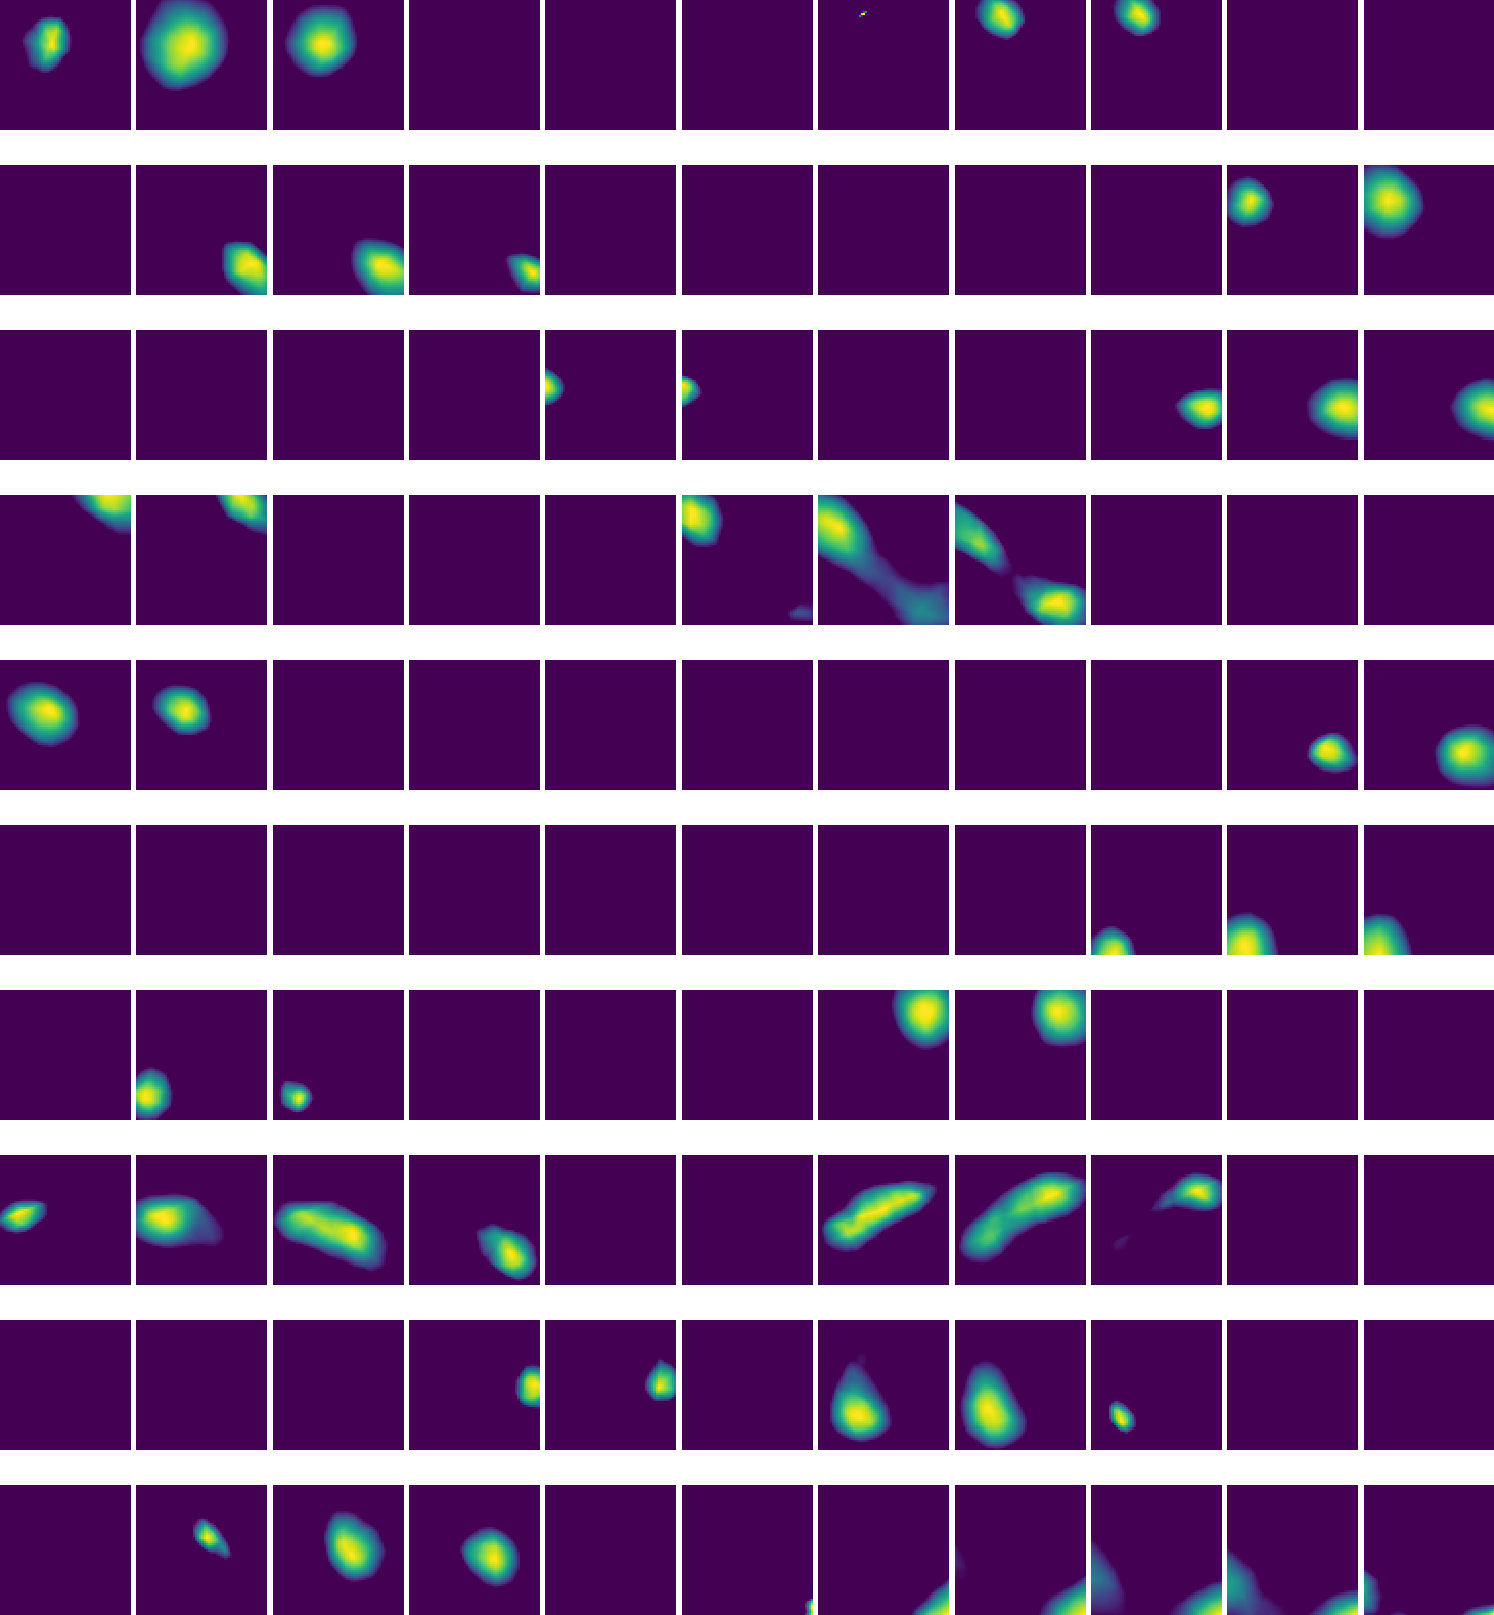

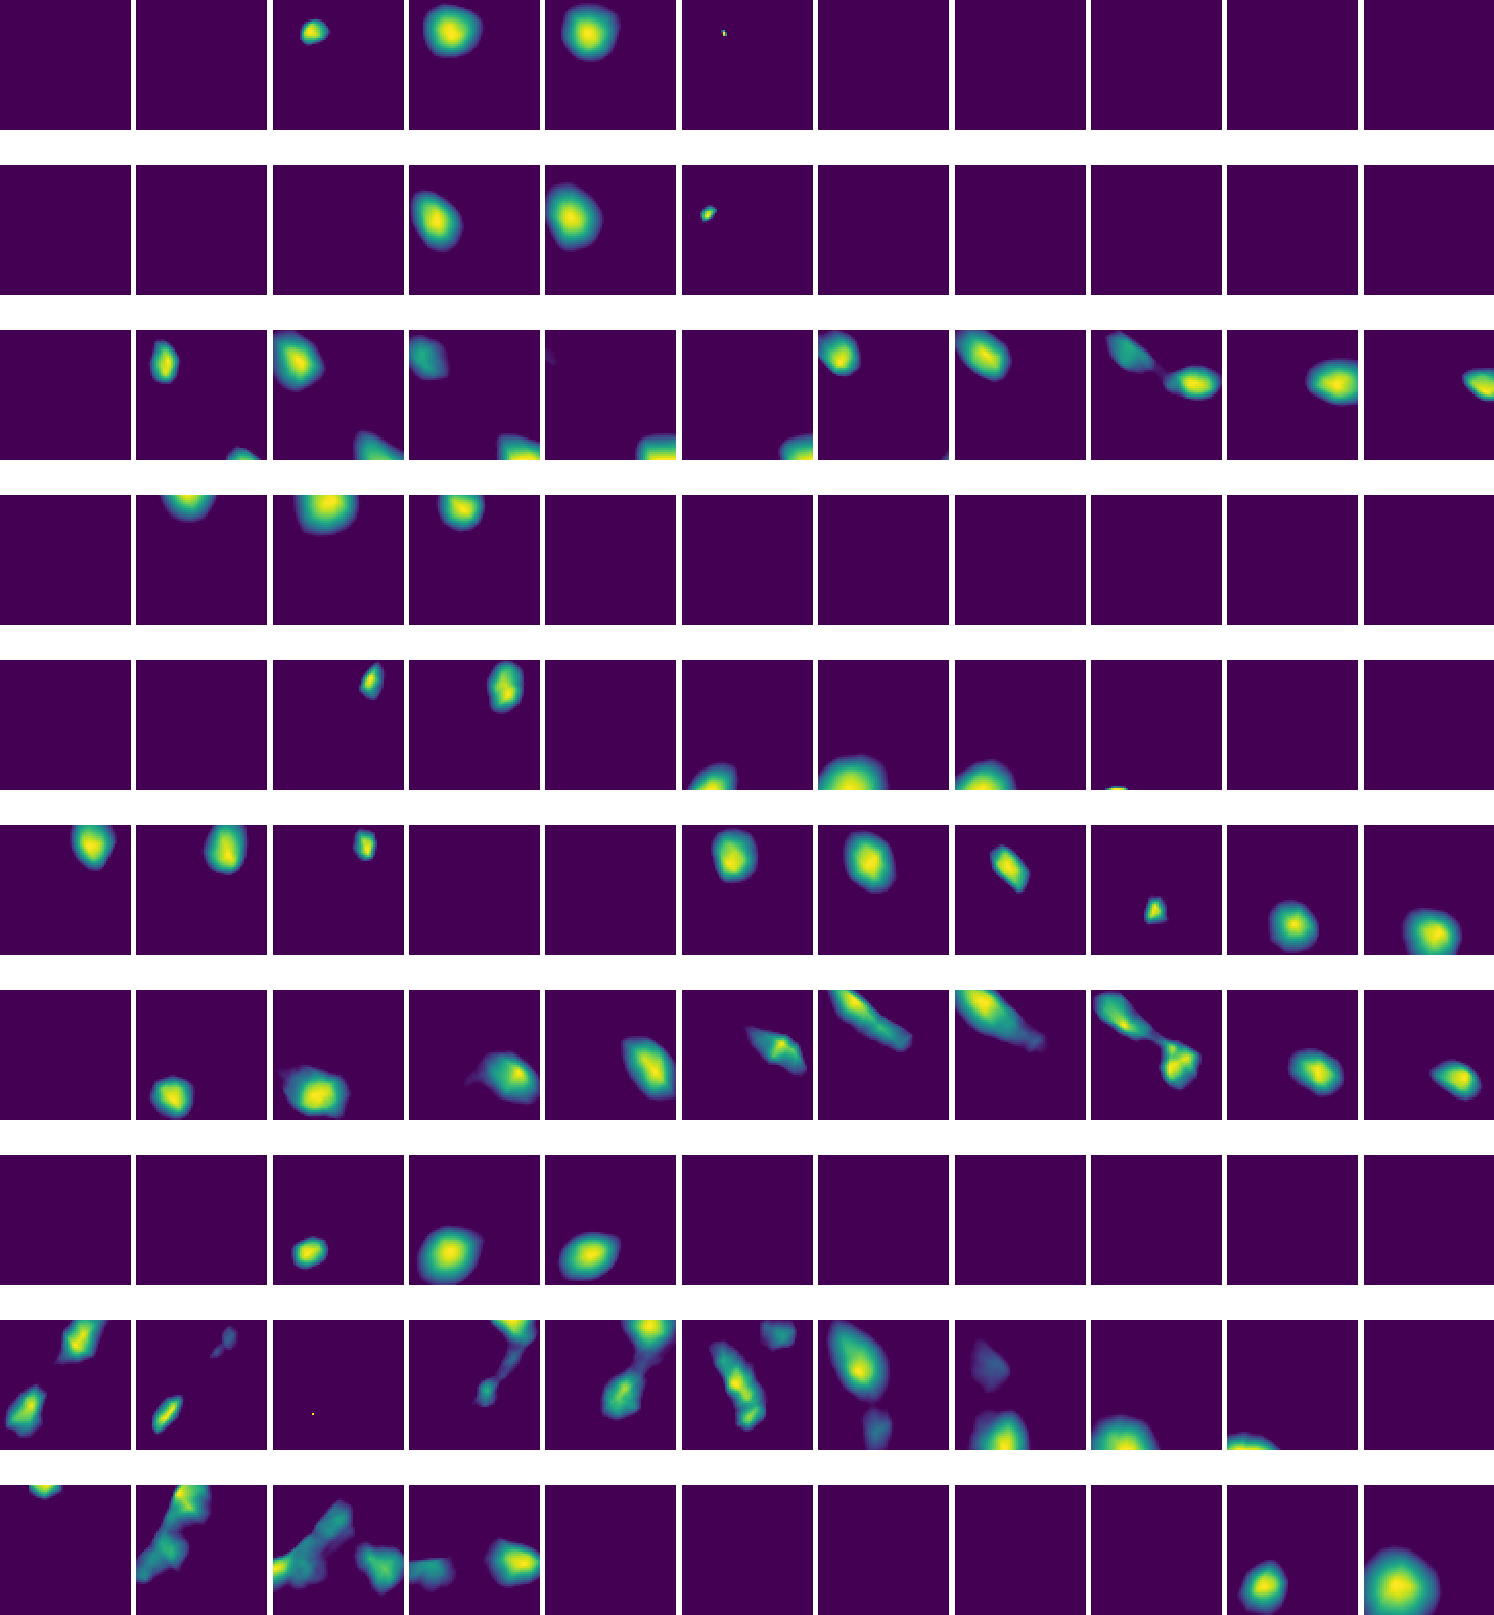

## UMAP

In [133]:
contexts = [-2, -1, 0, 1, 2]
contexts = [-1, 0, 1]
context_colors = [cmap(i) for i in np.linspace(0, 1, len(contexts))]

In [134]:
# Load model
model = models["256_context"][0]

# visualize representations
n_plot = 2000               # For umap trajectories choose 2000, for maps something like 50000
timesteps = 10
bins = 32
context_in_initial = True

genny = SimpleDatasetMaker()

representations, colors, ratemaps = [], [], []
for i, context in enumerate(contexts):
    
    # Generate dataset
    r, v = genny.generate_dataset(n_plot, timesteps)
    
    # BSR
    c = torch.ones(n_plot, timesteps-1, 1) * context
    input = torch.cat((v, c), dim = -1)
    
    # Get initial input
    if context_in_initial:
        initial_input = torch.cat((r[:, 0], c[:, 0]), dim=-1)
    else:
        initial_input = r[:, 0]
    
    # Get spatial representation
    p,_ = model.spatial_representation(input, model.p0(initial_input)[None])
    p = p.detach().numpy()
    ps = p.reshape(-1, p.shape[-1])
    
    rs = r[:, 1:].detach().numpy().reshape(-1, 2)
    ratemap, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1], ps.T, bins=bins)
    
    representations.append(ps)
    colors.extend([context_colors[i]] * ps.shape[0])
    ratemaps.append(ratemap.reshape(model.n_out, -1).T)

# Concatenate
representations = np.concatenate(representations, axis=0)
ratemaps = np.concatenate(ratemaps, axis=0)

UMAP on individual concatenated trajectories

In [136]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
umap_trajectories = reducer.fit_transform(representations)

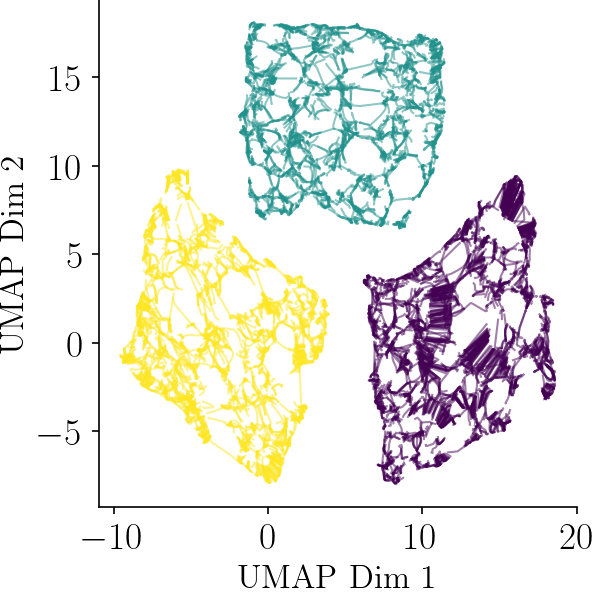

python3.10(13465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [137]:
fig, ax = plt.subplots(figsize=(4, 4))
for i, trajs in enumerate(np.split(umap_trajectories, len(contexts))):
    trajs = trajs.reshape(-1, timesteps-1, 2)
    for traj in trajs:
        ax.plot(traj[:, 0], traj[:, 1], color=context_colors[i], lw=1, alpha=0.5)
for i, n in enumerate(np.linspace(0, umap_trajectories.shape[0]-1, len(contexts)).astype(int)):
    ax.scatter(umap_trajectories[n, 0], umap_trajectories[n, 1], color=context_colors[i], label=f"c = {contexts[i]}", s=5)
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel('UMAP Dim 1')
ax.set_ylabel('UMAP Dim 2')
plt.show()
fig.savefig(os.path.join(figure_path, 'rnn_context_umap_trajectories.svg'), transparent=True)

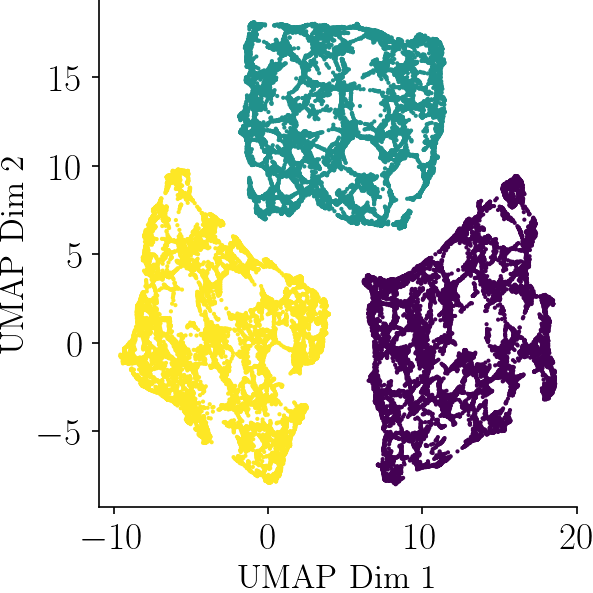

In [138]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(umap_trajectories[:, 0], umap_trajectories[:, 1], color=colors)
for i, n in enumerate(np.linspace(0, umap_trajectories.shape[0]-1, len(contexts)).astype(int)):
    ax.scatter(umap_trajectories[n, 0], umap_trajectories[n, 1], color=colors[n], label=f"c = {contexts[i]}", s=5)
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel('UMAP Dim 1')
ax.set_ylabel('UMAP Dim 2')
# ax.set_aspect('equal')
plt.show()

fig.savefig(os.path.join(figure_path, 'rnn_context_umap_trajectories_scatter.svg'), transparent=True)

UMAP on context maps

In [128]:
ratemap_colors, ratemap_labels = [], []
for i in range(len(contexts)):
    ratemap_colors.extend([context_colors[i]] * bins**2)
    ratemap_labels.extend([contexts[i]] * bins**2)
    
ratemaps[np.isnan(ratemaps)] = 0

reducer = umap.UMAP(n_components=2)
umap_trajectories_maps = reducer.fit_transform(ratemaps)

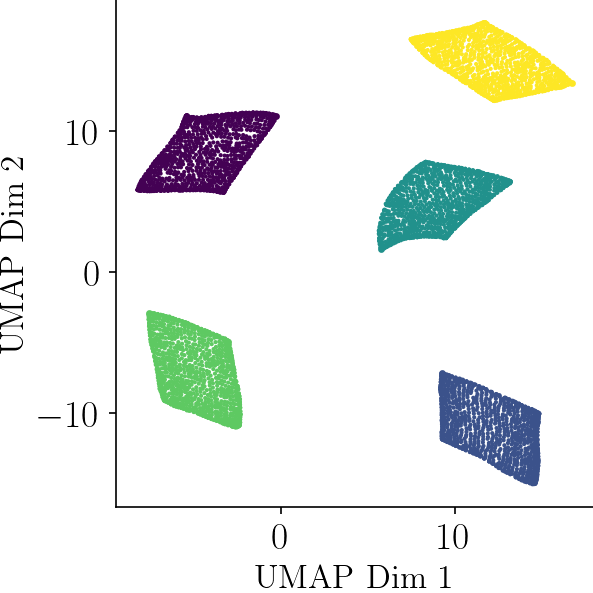

In [132]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(umap_trajectories_maps[:, 0], umap_trajectories_maps[:, 1], color=ratemap_colors)
for i in range(len(contexts)):
    ax.scatter(umap_trajectories_maps[i * bins**2, 0], umap_trajectories_maps[i * bins**2, 1], color=ratemap_colors[i * bins**2], label=f"c = {contexts[i]}", s=5)
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel('UMAP Dim 1')
ax.set_ylabel('UMAP Dim 2')
plt.show()

fig.savefig(os.path.join(figure_path, 'rnn_context_umap_maps.svg'), transparent=True)

Orthogonal transformations

In [140]:
def get_orthogonal_transformation(A, B):
    """
    Finds an orthogonal transformation matrix T that maps A to B and minimizes the Frobenius norm of the difference between A' and B.
    This is also known as the Orthogonal Procrustes problem.
    
    Parameters
    ----------
    A : np.ndarray
        Matrix of shape (n_units, positions)
    B : np.ndarray
        Matrix of shape (n_units, positions)
    
    Returns
    -------
    T : np.ndarray
        Orthogonal transformation matrix of shape (n_units, n_units)
        
    References
    ----------
    https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem
    """
    # Flatten
    if len(A.shape) == 3:
        A = A.reshape(A.shape[0], -1)
    if len(B.shape) == 3:
        B = B.reshape(B.shape[0], -1)
    
    # Center the data
    A_centered = A - np.mean(A, axis=1, keepdims=True)
    B_centered = B - np.mean(B, axis=1, keepdims=True)
           
    # Compute the cross-covariance matrix
    C = A_centered @ B_centered.T

    # Compute the SVD of the cross-covariance matrix
    U, _, Vt = np.linalg.svd(C)

    # Calculate the transformation matrix
    T = Vt.T @ U.T

    return T

In [105]:
from scipy.stats import ortho_group
from tqdm import tqdm


model_name = "256_context"
model = models[model_name][0]
bins = 128
n_traj = 100000
timesteps = 10
context_in_initial = True
contexts = np.linspace(-2, 2, 21)

T_random_fixed = ortho_group.rvs(dim=model.n_out)
ratemaps = [get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=n_traj, context=c, intialization="position_and_context").reshape(model.n_out, -1) for c in tqdm(contexts)]


100%|██████████| 21/21 [01:00<00:00,  2.90s/it]


In [107]:
df = []
for i, c1 in enumerate(tqdm(contexts)):

    ratemaps1 = ratemaps[i]
    
    for j, c2 in enumerate(contexts):
    
        ratemaps2 = ratemaps[j]
                
        # Find orthogonal transformation, apply
        T = get_orthogonal_transformation(ratemaps1, ratemaps2)
        ratemaps2_approx = T @ ratemaps1
        mse = np.mean((ratemaps2 - ratemaps2_approx) ** 2)
        euc = np.linalg.norm(ratemaps2 - ratemaps2_approx, axis=1).mean()
        
        # Also do this for a random orthogonal matrix
        T_random = ortho_group.rvs(dim=T.shape[0])
        ratemaps2_approx_random = T_random @ ratemaps1
        mse_random = np.mean((ratemaps2 - ratemaps2_approx_random) ** 2)
        euc_random = np.linalg.norm(ratemaps2 - ratemaps2_approx_random, axis=1).mean()
        
        # Apply fixed random transformation
        ratemaps2_approx_random_fixed = T_random_fixed @ ratemaps1
        mse_random_fixed = np.mean((ratemaps2 - ratemaps2_approx_random_fixed) ** 2)
        euc_random_fixed = np.linalg.norm(ratemaps2 - ratemaps2_approx_random_fixed, axis=1).mean()
            
        df.append({
                "context_1": c1,
                "context_2": c2,
                "mse": mse,
                "mse_random": mse_random,
                "mse_random_fixed": mse_random_fixed,   
                "euc": euc,
                "euc_random": euc_random,
                "euc_random_fixed": euc_random_fixed,
        })
    
df = pd.DataFrame(df)


100%|██████████| 21/21 [01:42<00:00,  4.88s/it]


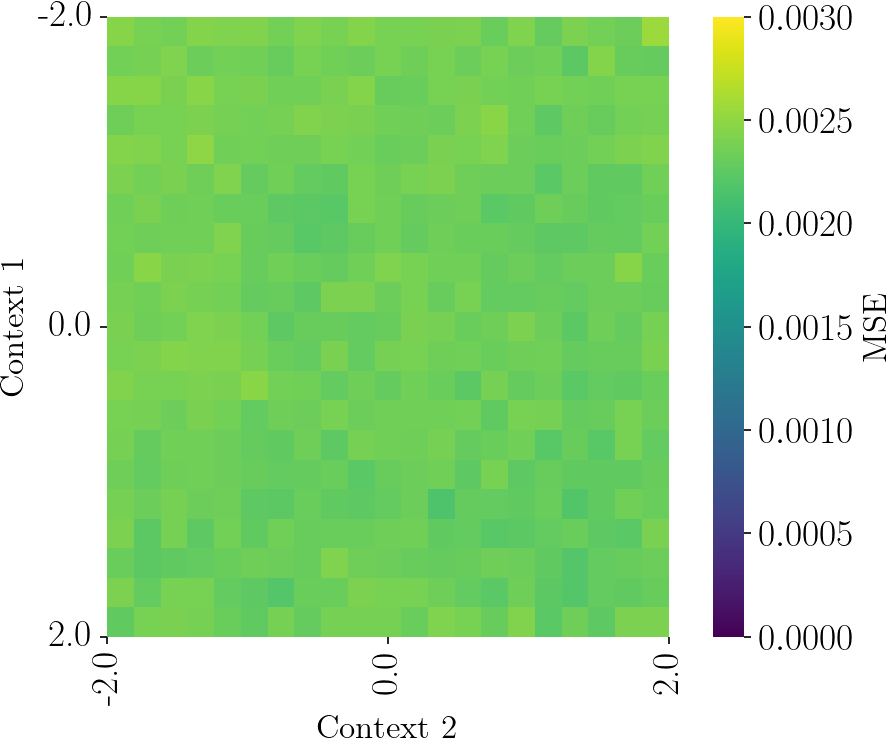

In [133]:
from matplotlib.colors import LogNorm

error_type = "mse_random"
pivot_df = df.pivot(index="context_1", columns="context_2", values=error_type)

plt.figure(figsize=(6, 5), constrained_layout=True)

# Set up the LogNorm normalization
# log_norm = LogNorm(vmin=pivot_df.min().min(), vmax=pivot_df.max().max())
log_norm = LogNorm(vmin=0.000030, vmax=0.01)

# Plot the heatmap with LogNorm
g = sns.heatmap(
    pivot_df,
    annot=False,
    cmap='viridis',
    vmin=0,
    vmax=0.003,
    # norm=log_norm  # Apply log scaling on the colorbar
)

g.set_xticks(np.linspace(0, pivot_df.shape[1], 3))
g.set_yticks(np.linspace(0, pivot_df.shape[0], 3))
g.set_xticklabels(np.round(np.linspace(pivot_df.columns[0], pivot_df.columns[-1], 3), 2))
g.set_yticklabels(np.round(np.linspace(pivot_df.index[0], pivot_df.index[-1], 3), 2))
g.set_ylabel("Context 1")
g.set_xlabel("Context 2")
cbar = g.collections[0].colorbar
cbar.set_label(f"MSE")

save_string = '_'.join(error_type.lower().split(' '))

g.figure.savefig(os.path.join(figure_path, f'rnn_context_{save_string}_heatmap_log.svg'), transparent=True)

Examples of orthogonal transformations

In [147]:
# Load model
model_name = "256_context"
model = models[model_name][0]

# Define contexts
context_1 = -1
context_2 = 1

context_in_initial = True
bins = 128
n_traj = 50000
timesteps = 10

# Get ratemaps
ratemaps1 = get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=n_traj, context=context_1, intialization="position_and_context").reshape(model.n_out, -1)
ratemaps2 = get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=n_traj, context=context_2, intialization="position_and_context").reshape(model.n_out, -1)

# Transform ratemaps1 to ratemaps2
T = get_orthogonal_transformation(ratemaps1, ratemaps2)
ratemaps1_t = T @ ratemaps1

# Reshape
ratemaps1_t = ratemaps1_t.reshape(model.n_out, bins, bins)
ratemaps2 = ratemaps2.reshape(model.n_out, bins, bins)


In [148]:
from scipy.stats import pearsonr

p_df = []
for i in range(ratemaps1.shape[0]):
    p_df.append({
        "unit": i,
        "kind": "Context 1, Context 2",
        "r": pearsonr(ratemaps1[i].flatten(), ratemaps2[i].flatten())[0],
        "mean": ratemaps2[i].mean(),
    })
    p_df.append({
        "unit": i,
        "kind": "Transformed, Context 2",
        "r": pearsonr(ratemaps2[i].flatten(), ratemaps1_t[i].flatten())[0],
        "mean": ratemaps2[i].mean(),
    })
p_df = pd.DataFrame(p_df)

/Users/frederikrogge/miniforge3/envs/bsr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


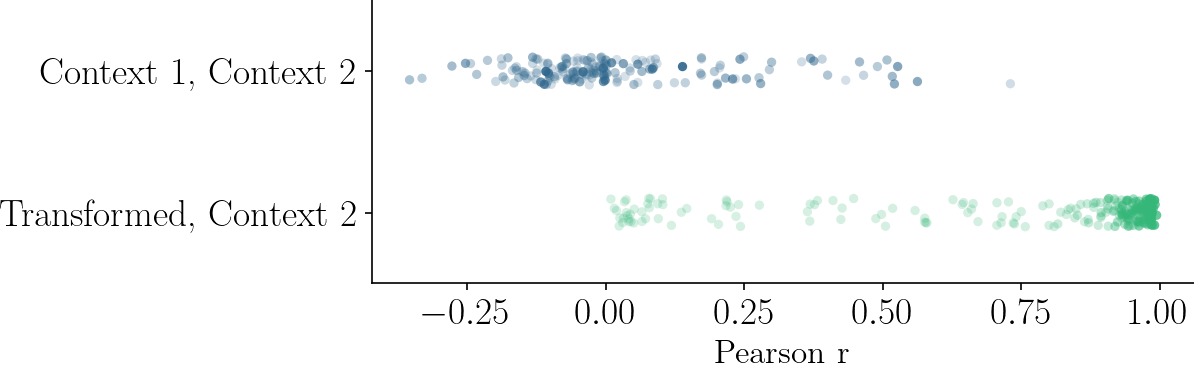

In [150]:
fig, ax = plt.subplots(figsize=(8, 2.5))
palette = sns.color_palette("viridis", 2)
kind_colors = {"Context 1, Context 2": palette[0], "Transformed, Context 2": palette[1]}

# Alpha should be between 0.2 and 1
p_df["alpha"] = 0.2 + (p_df['mean'] - p_df['mean'].min()) * (1 - 0.2) / (p_df['mean'].max() - p_df['mean'].min())
p_df["y"] = p_df['kind'].map({"Context 1, Context 2": 1, "Transformed, Context 2": 0})

for kind in p_df['kind'].unique():
    kind_data = p_df[p_df['kind'] == kind]
    ax.scatter(
        kind_data['r'], 
        kind_data['y'] + np.random.uniform(-0.1, 0.1, kind_data.shape[0]),  # Add some random "jitter" to the y-axis
        alpha=kind_data['alpha'],  
        color=kind_colors[kind],  
        label=kind, 
        edgecolor='none',  
        linewidth=0.0,
        s=20
    )
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel("Pearson r")
ax.set_ylabel("")
ax.set_yticks([0, 1])
ax.set_yticklabels(["Transformed, Context 2", "Context 1, Context 2"])
# ax.legend(["Context 1, Context 2", "Transformed, Context 2"], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig.savefig(os.path.join(figure_path, "rnn_pearson_orthogonal_transformation_scatter.svg"), transparent=True)

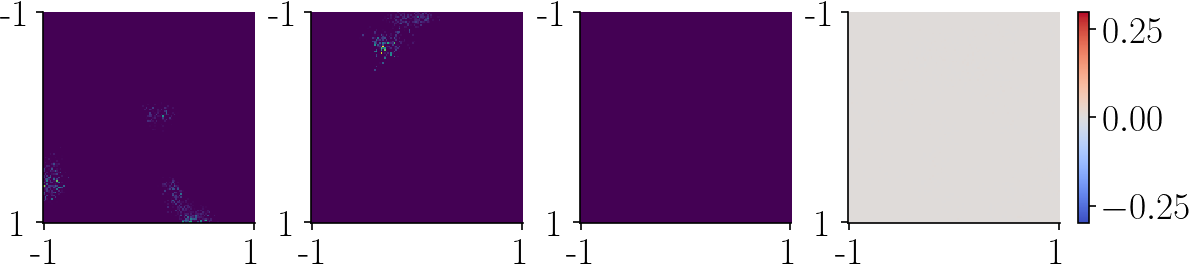

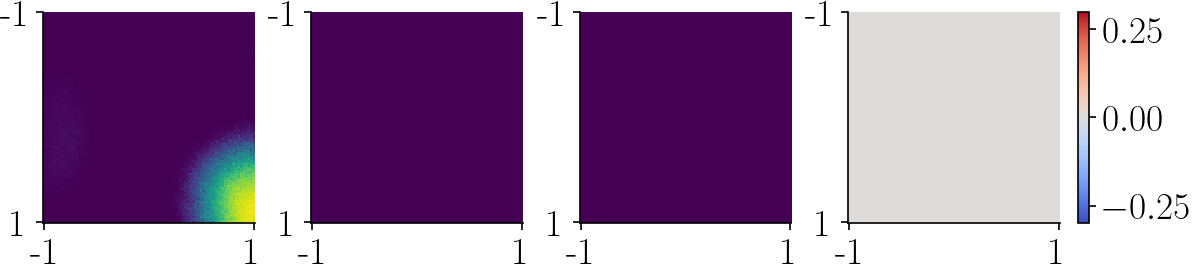

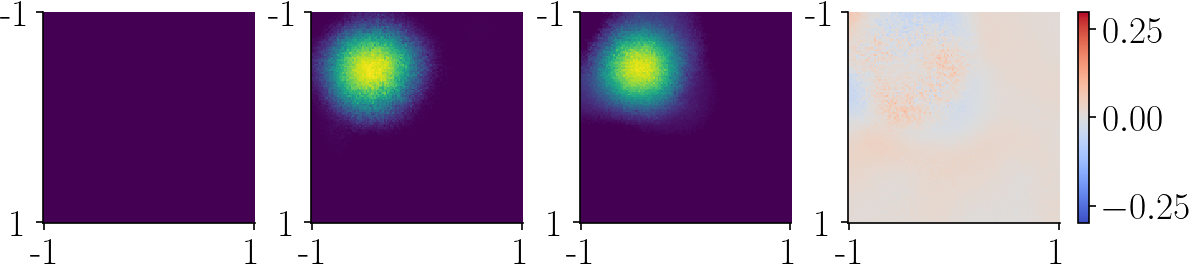

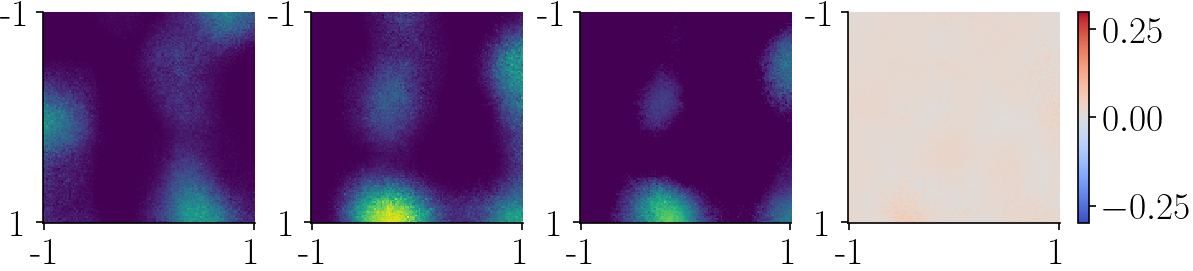

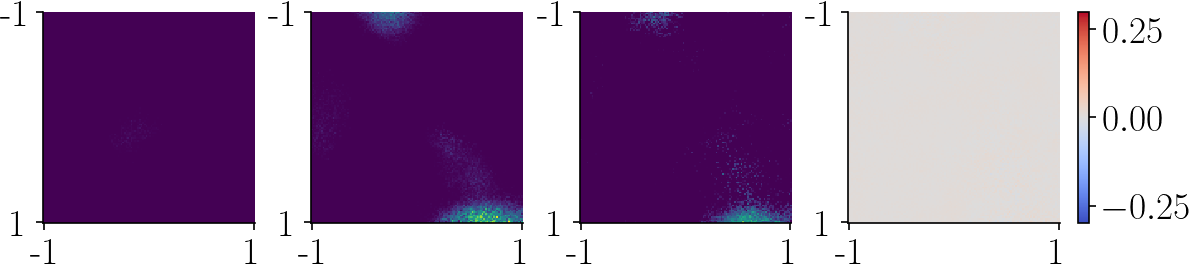

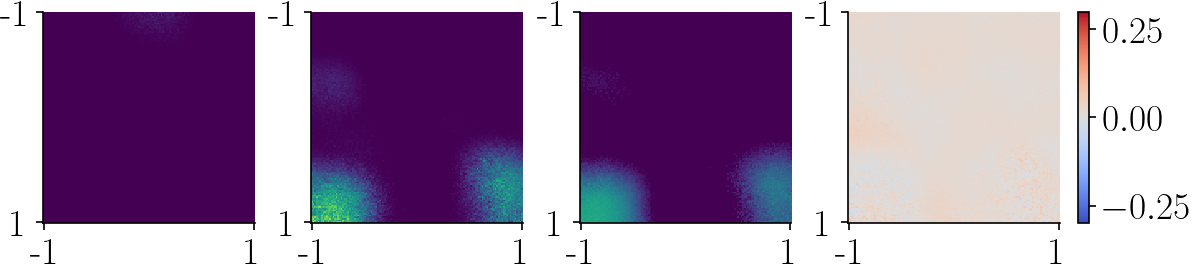

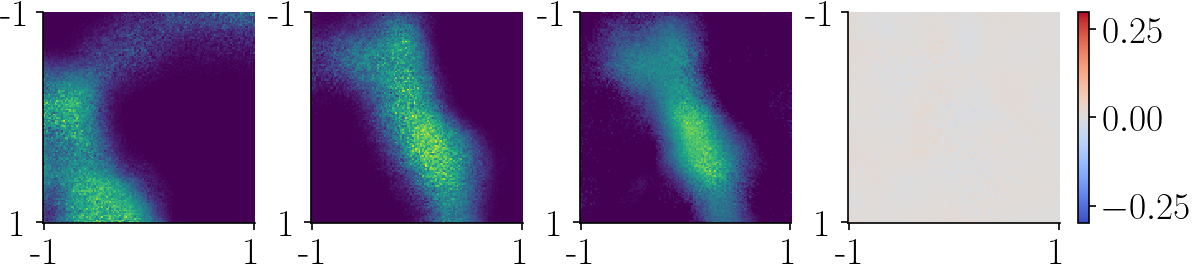

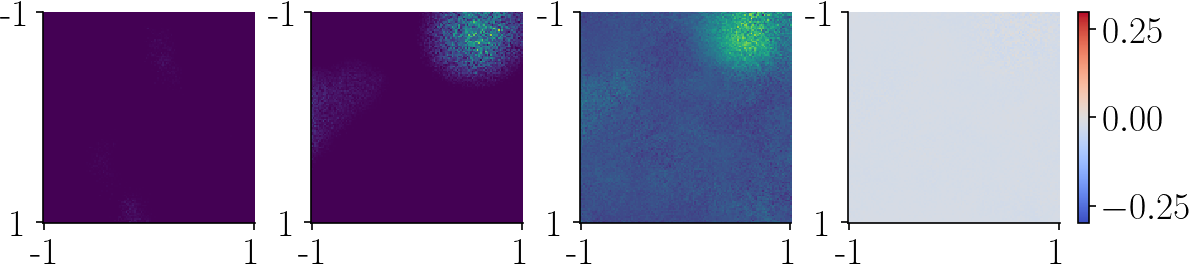

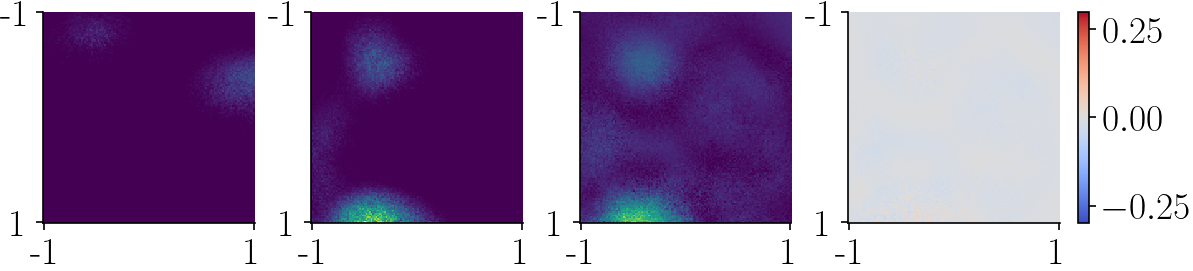

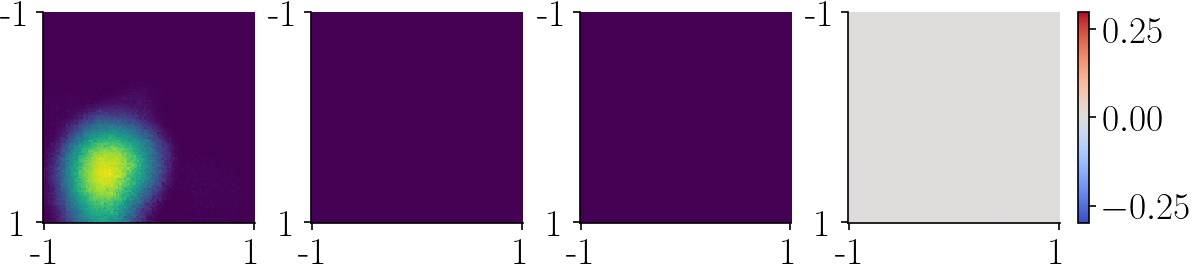

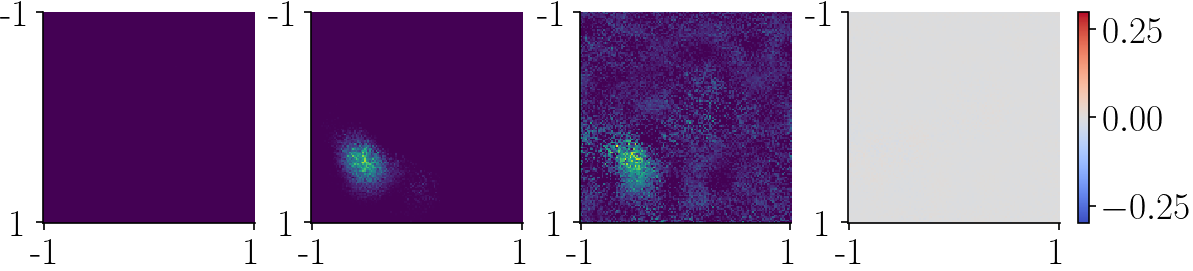

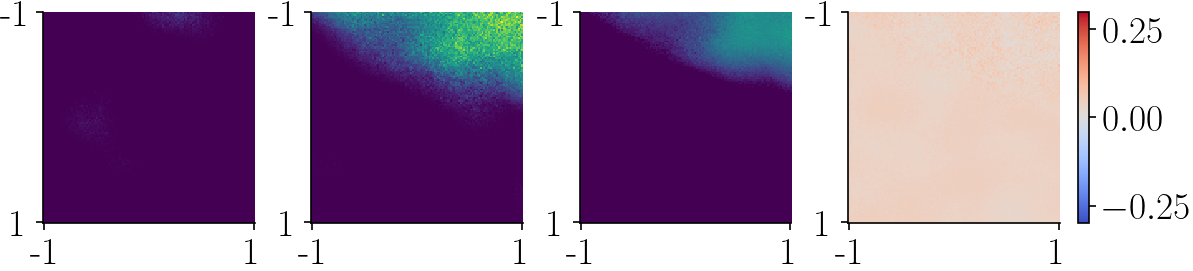

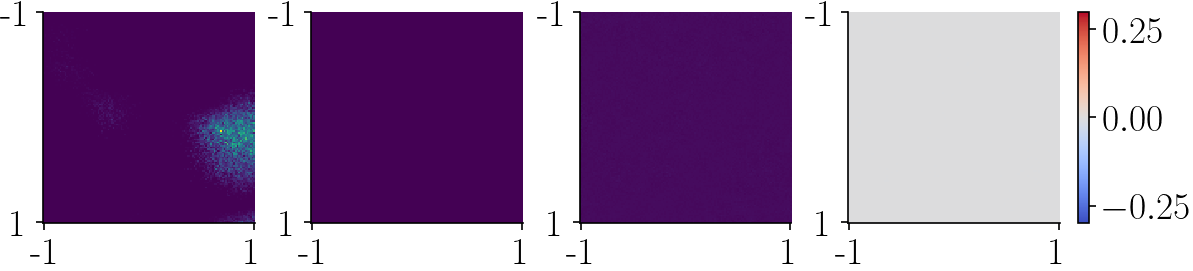

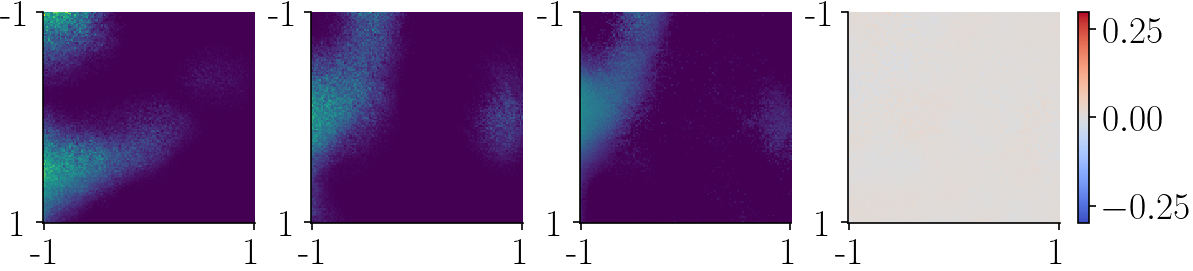

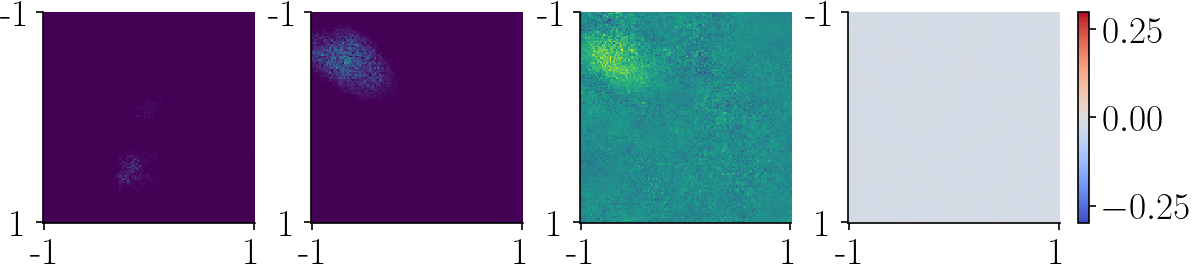

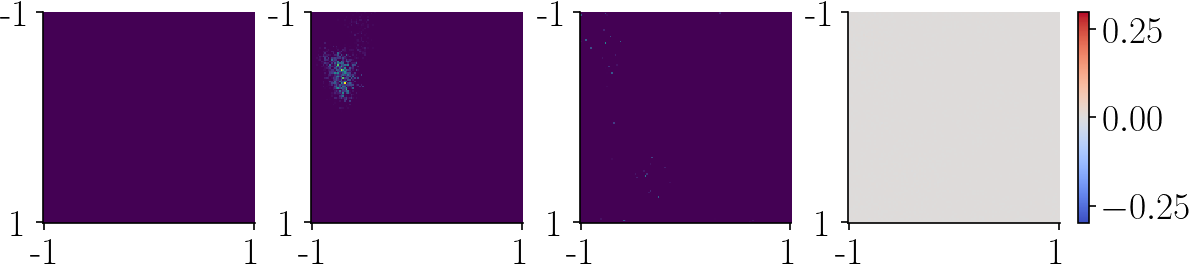

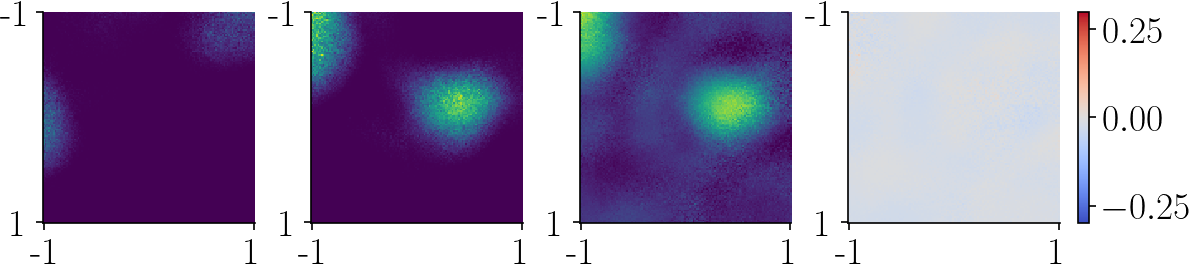

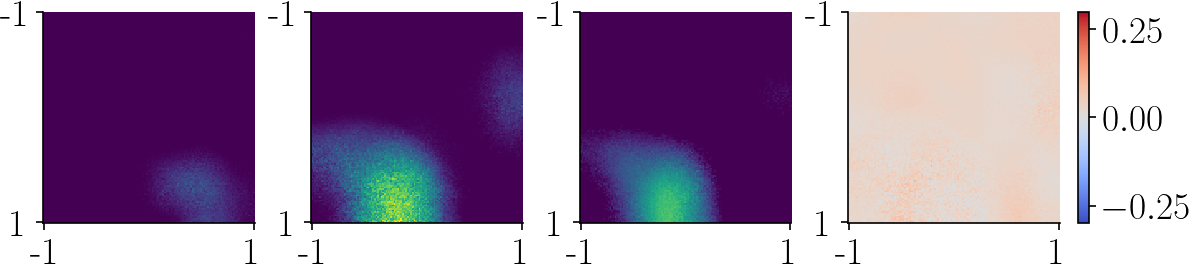

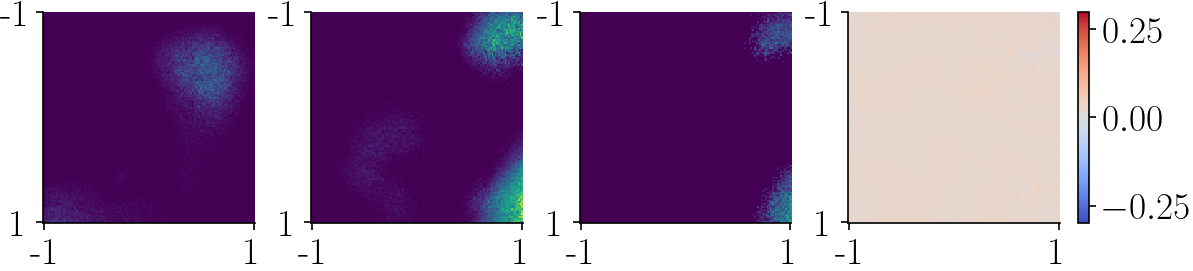

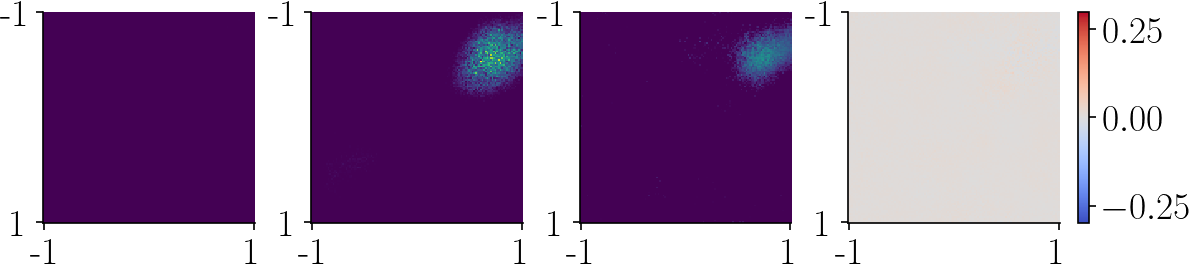

In [139]:
for i in range(20):

    max_val = np.max([ratemaps1[i].max(), ratemaps2[i].max(), ratemaps1_t[i].max()])
    fig, axs = plt.subplots(figsize=(8, 2), ncols=4)
    axs[0].imshow(ratemaps1[i].reshape(bins, bins), cmap="viridis", vmin=0, vmax=max_val)   
    axs[1].imshow(ratemaps2[i], cmap="viridis", vmin=0, vmax=max_val)
    axs[2].imshow(ratemaps1_t[i], cmap="viridis", vmin=0, vmax=max_val)
    im = axs[3].imshow(ratemaps2[i] - ratemaps1_t[i], cmap="coolwarm", vmin=-0.3, vmax=0.3)
    fig.colorbar(im, ax=axs[3], orientation='vertical', fraction=.05)
    
    for ax in axs:
        ax.set_xticks([0, bins-1])
        ax.set_yticks([0, bins-1])
        ax.set_xticklabels([-1, 1])
        ax.set_yticklabels([-1, 1])
    plt.show()
    fig.savefig(os.path.join(figure_path, f'rnn_transformation_example_{i}.png'), transparent=True)
